# Pose Bowl: Object Detection


<a id="import-libraries"></a>

## 📚 | Import Libraries 

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.io import read_image
from torchvision import tv_tensors
import utils

<a id="configuration"></a>
## ⚙️ | Configuration

In [2]:
PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
DEV_DIRECTORY = PROJ_DIRECTORY / "data_dev"
IMAGES_DIRECTORY = DEV_DIRECTORY / "images"

## 🩼 | Helper Functions

In [116]:
def get_bbox(image_id, labels):
    """Get bbox coordinates as list from dataframe for given image id."""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values

def display_image(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=None):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    fig, ax = plt.subplots()
    # cv2 reads images as BGR order; we should flip them to RGB for matplotlib
    # ref: https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

<a id="datasets"></a>
## 🍚 | DataSets

In [117]:
train_meta = pd.read_csv(DEV_DIRECTORY / "train_metadata.csv", index_col="image_id")
train_labels = pd.read_csv(DEV_DIRECTORY / "train_labels.csv", index_col="image_id")

In [118]:
train_meta.shape, train_labels.shape

((25801, 2), (25801, 4))

In [119]:
train_labels.head()

,xmin,ymin,xmax,ymax
image_id,,,,
0001954c9f4a58f7ac05358b3cda8d20,0,277,345,709
00054819240f9d46378288b215dbcd3a,753,602,932,725
000dbf763348037b46558bbcb6a032ac,160,434,203,481
000e79208bebd8e84ce6c22fd8612a0d,70,534,211,586
000f13aff94499d03e3997afc55b0aa0,103,0,312,193


In [120]:
train_meta.head()

,spacecraft_id,background_id
image_id,,
0001954c9f4a58f7ac05358b3cda8d20,24,247
00054819240f9d46378288b215dbcd3a,14,10
000dbf763348037b46558bbcb6a032ac,19,17
000e79208bebd8e84ce6c22fd8612a0d,14,15
000f13aff94499d03e3997afc55b0aa0,28,15


In [121]:
# we didn't download the full training set, so add a column indicating which images are saved locally
train_meta["exists"] = train_meta.index.to_series().map(lambda x: (IMAGES_DIRECTORY / f"{x}.png").exists())
train_labels["exists"] = train_labels.index.to_series().map(lambda x: (IMAGES_DIRECTORY / f"{x}.png").exists())

# filter our metadata and training data down to only the images we have locally
train_meta = train_meta[train_meta.exists]
train_labels = train_labels[train_labels.exists]

print(train_meta.shape, train_labels.shape)

# Check indexes are the same
if train_meta.index.equals(train_labels.index):
    print("The indexes are the same.")
else:
    print("The indexes are different.")

(1579, 3) (1579, 5)
The indexes are the same.


In [129]:
# Create pytorch DataSet
class SpacecraftDataset(torch.utils.data.Dataset):
    def __init__(self, labels_df, meta_df, imgs_dir=IMAGES_DIRECTORY, transforms=None):
        self.imgs_dir = imgs_dir
        self.labels_df = labels_df # dataframe of indexs and bbox coordinates
        self.meta_df = meta_df
        self.img_idxs = labels_df.index.tolist()
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # Get image id and path
        img_id = self.img_idxs[idx]
        img_path = str(Path(self.imgs_dir, img_id + '.png'))
        n_objs = 1
        
        # Load image
        img = read_image(img_path) / 255

        # Get spacecraft id
        # labels = self.meta_df.loc[idxs[0]].loc['spacecraft_id']
        labels = torch.ones(n_objs, dtype=torch.int64)

        # Get bbox coordinates
        bbox = self._get_bbox(img_id)
        
        # Convert data to format needed by model.
        target = {}
        target['boxes'] = torch.from_numpy(bbox).reshape((1,4))
        target['labels'] = labels

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.img_idxs)

    def _get_bbox(self, image_id):
        return self.labels_df.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.astype('int')

In [130]:
# Define a collate function to deal with format of map-type (i.e dictionaries) dataset
def collate_fn(batch):
    return list(zip(*batch))

In [138]:
# Test a forward pass
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = SpacecraftDataset(train_labels, train_meta)
data_loader = DataLoader(
    dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn
)

# For training
images, targets = next(iter(data_loader))
images = list(images)
targets = list(targets)
output = model(images, targets)
print(output)

{'loss_classifier': tensor(0.4383, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1229, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0200, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0120, grad_fn=<DivBackward0>)}


In [165]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [164]:
# For evaluation
def images2tensors(img_ids):
    tensors = []
    for id in img_ids:
        img_path = str(Path(IMAGES_DIRECTORY, id + '.png'))
        img = read_image(img_path) / 255
        tensors.append(img)
    return tensors

img_ids = train_labels.index.to_list()[:3]
img_tensors = images2tensors(img_ids)
model.eval()
predictions = model(img_tensors)
print(predictions[2])

{'boxes': tensor([[ 631.0053,  274.1492,  653.5613,  310.7522],
        [  28.0372,   15.5272, 1280.0000,  964.4224],
        [ 630.3187,  273.9125,  653.0670,  311.5308]],
       grad_fn=<StackBackward0>), 'labels': tensor([37, 72, 38]), 'scores': tensor([0.9267, 0.0991, 0.0656], grad_fn=<IndexBackward0>)}


In [ ]:
# Divide train_meta into test and validation sets.

# Explore data augmentation.

# Move validation images into data/images directory

# Create a subset of training set for dummy training.

# Set up the model for finetuning.

In [157]:
def display_prediction(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=None):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    fig, ax = plt.subplots()
    # cv2 reads images as BGR order; we should flip them to RGB for matplotlib
    # ref: https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = labels
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

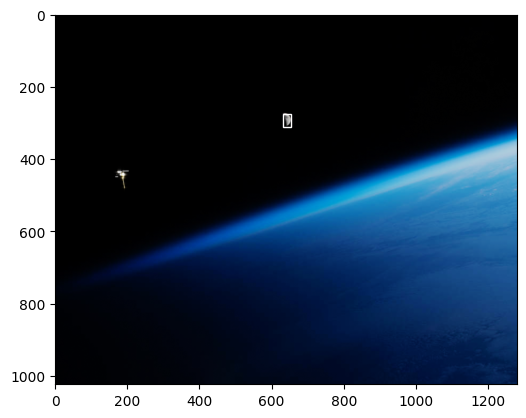

In [163]:
display_prediction('000dbf763348037b46558bbcb6a032ac', show_bbox=True, labels=[ 630.3187,  273.9125,  653.0670,  311.5308] )

<a id="model"></a>
## 🤖 | Model

In [46]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/jsh/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:20<00:00, 8.12MB/s] 


In [46]:
# For training
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)


In [47]:
boxes[0][0]

tensor([0.3648, 0.9368, 0.7403, 1.0433])

<a id="loss-and-optimizer"></a>
## 🔍 | Loss & Optimizer

<a id="training"></a>
## 🚂 | Training

## 📋 | Result

The `train_labels.csv` contains the bounding box information for the target spacecraft in each image.

In [6]:
train_labels.head()

,xmin,ymin,xmax,ymax
image_id,,,,
0001954c9f4a58f7ac05358b3cda8d20,0,277,345,709
00054819240f9d46378288b215dbcd3a,753,602,932,725
000dbf763348037b46558bbcb6a032ac,160,434,203,481
000e79208bebd8e84ce6c22fd8612a0d,70,534,211,586
000f13aff94499d03e3997afc55b0aa0,103,0,312,193


Let's look at a few example images to get a feel for what's in this dataset.

<a id="demo-submission"></a>

## Section 2: Demo submission
Now that we've had a chance to get a feel for the data, it's time to walk through the steps for creating a competition submission.

This is a **code submission competition**, so our focus for now will be on creating that submission in the correct format, and less so on the accuracy of the predictions. To get you started, we'll be using a YOLO model to try to identify the target spacecraft in 100 local test images.

If you haven't already read through the following resources, now would be a great time to do that:
* [Code Submission Format page](https://www.drivendata.org/competitions/260/spacecraft-detection/page/835/): An introduction to the code submission setup and how to make a valid submission.
* [Runtime Repository README](https://github.com/drivendataorg/spacecraft-pose-object-detection-runtime): Details on the competition runtime and how to use this repository effectively.

### Using the `/data` directory

The `/data` directory in this runtime repository plays two important roles:

* When you are testing your solution _locally_, the contents of `/data` will be mounted on the Docker container that simulates our code execution platform (further below, we'll walk through the specifics of how to do these test runs)
* When you make a submission on the DrivenData _platform_, the contents of `/data` that get mounted to the Docker container will be the unseen test data that ultimately determines your rank on the leaderboard.

To develop your submission locally, you should add a subset of the challenge data to `/data` and treat this as your local test set. We'll demonstrate one way to do that next...

First, let's select a random subset of 100 images in `/data_dev` to treat as our local test set.

In [22]:
test_images = train_meta.sample(100, random_state=1).index.tolist()
test_images[:5]

['059af2a88bfa9e8f99de278154acad12',
 '0384647db5822c58e10acb2f6e9cae88',
 '0e24bf82001019665f91889c24d733ca',
 '01cb19b86b408a71407f9dd293d43e4a',
 '02a88fc07c2709f50807da1cfb29612c']

Next, we'll move these files into the `/data` directory.

In [23]:
import shutil

dest_dir = DATA_DIRECTORY / "images"
if not dest_dir.exists():
    dest_dir.mkdir(parents=True, exist_ok=True)

for img in test_images:
    shutil.copy2(IMAGES_DIRECTORY / f"{img}.png", dest_dir / f"{img}.png")

Next we'll add a "submission format" CSV file to `/data`.

> Note: A submission format file in this case is simply a CSV file that has the correct column and row indices required for a valid submission. Using this type of standard file is a useful way to ensure that all participants understand how their submission needs to be formatted in order to be accepted, and we tend to use these in most of our challenges.

A submission format file for the full training set should already be present in `/data_dev`. We'll make a copy of this that only includes rows pertaining to the images in our local test set, and save it in `/data`.

In [24]:
submission_format = pd.read_csv(DEV_DIRECTORY / "submission_format.csv", index_col="image_id")
submission_format_val = submission_format.loc[test_images]
submission_format_val.to_csv(DATA_DIRECTORY / "submission_format.csv")

Let's also create a version of the labels file that only includes rows pertaining to our local test set. We can use this later for local scoring (see below).

In [25]:
train_labels = pd.read_csv(DEV_DIRECTORY / "train_labels.csv", index_col="image_id")
test_labels = train_labels.loc[test_images]
test_labels.to_csv(DATA_DIRECTORY / "test_labels.csv")

### Download a pretrained model

For this benchmark example, we will rely on YOLO, a commonly used algorithm for object detection. This will suit our purposes for demonstrating a very basic baseline approach, but you should explore more sophisticated methods yourself.

To download the latest v8 YOLO model, we'll use the `ultralytics` library. The code below will download the model and move it into the `example_benchmark` directory, where we're assembling the components of our submission.

In [26]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

shutil.move('yolov8n.pt', PROJ_DIRECTORY / "example_benchmark" / "yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:01<00:00, 6.22MB/s]


PosixPath('/Users/jsh/code/drivendata/spacecraft-pose-object-detection-runtime/example_benchmark/yolov8n.pt')

### Review the benchmark submission scripts

Now let's take a look at the 2 files in `/example_benchmark`. This is the directory we are going to convert into a `submission.zip` file, which you can submit for the challenge.
* The `main.sh` shell script is a _required_ file for any submission to this challenge. Our code execution platform will run this script, and you can have it call other scripts and resources as needed for your submission.
* The `main.py` Python script is called by `main.sh` in this benchmark example, and this is where the work of generating predictions actually happens. There is no requirement that you also use Python here, but that's the approach we've taken since it is such a common one. The `main.py` script will iterate through all the images in the `submission_format.csv` and generate predictions using YOLO. If YOLO doesn't return a prediction, we simply generate a bounding box for the center of the image.

The `example_benchmark` directory should now contain the following files.  Note that we do need to include the `yolov8n.pt` file because the submission will have no internet access when running on our platform.
```
spacecraft-pose-object-detection-runtime/
└── example_benchmark/
    ├── main.py
    ├── main.sh
    └── yolov8n.pt
```

### Three commands to prepare your submission
To run and test the benchmark example, you just need to execute the following 3 commands:

1. [`make pull`](#make-pull)
2. [`make pack-benchmark`](#make-pack-benchmark)
3. [`make test-submission`](#make-test-submission)

These are defined in the project `Makefile` [here](https://github.com/drivendataorg/spacecraft-pose-object-detection-runtime/blob/main/Makefile). We'll walk through what each one does now.

<a id="make-pull"></a>

#### **`make pull`**

To ensure that all participants are using the same runtime environment, we have a publicly accessible docker image hosted on [Azure Container Registry](https://azure.microsoft.com/en-us/services/container-registry/).

The `make pull` command pulls the official version of the docker image and stores it locally. Having a local version of the competition image allows you to test your submission using the same image that is used during code execution.

> **Note:** This command can take a little while to run the first time you pull the image. But after that it will be relatively quick since you'll have all the layers cached locally. You don't need to pull the image again each time you test your submission, unless the image has changed.

In [17]:
!cd {PROJ_DIRECTORY} && make pull

docker pull spacecraftpose.azurecr.io/spacecraft-pose-object-detection:latest
latest: Pulling from spacecraft-pose-object-detection
Digest: sha256:025731e47e851c8f57363fc4d5a2e3fd44ec1a64f2089ba9d728ad7c8057f3a7
Status: Image is up to date for spacecraftpose.azurecr.io/spacecraft-pose-object-detection:latest
spacecraftpose.azurecr.io/spacecraft-pose-object-detection:latest


You should now have a local copy of the docker image, which you can verify by running:

In [27]:
!docker images | grep spacecraft-pose-object-detection

spacecraftpose.azurecr.io/spacecraft-pose-object-detection   latest    bc1d6eb59ba6   4 days ago     5.74GB


<a id="make-pack-benchmark"></a>

#### **`make pack-benchmark`** 
This command simply goes to your `example_benchmark` directory, zips the contents, and writes the zip archive to `submission/submission.zip`.

In [28]:
!cd {PROJ_DIRECTORY} && make pack-benchmark

mkdir -p submission/
cd example_benchmark; zip -r ../submission/submission.zip ./*
  adding: main.py (deflated 61%)
  adding: main.sh (deflated 26%)
  adding: yolov8n.pt (deflated 9%)


> **Note:** The `make pack-benchmark` command will check to see if you already have a `submission/submission.zip` and error if you do, so as not to overwrite existing work. If you already have this file, you'll need to manually remove it before running the command.

After running the above command, we should now have a new **`submission/submission.zip`**.
```
spacecraft-pose-object-detection-runtime/
├── benchmark_src/
│   ├── main.py
│   ├── main.sh
│   └── yolov8n.pt
└── submission/
    └── submission.zip   <---- new file, this is what gets submitted on platform
```

This is the file that we will eventually upload to the competition platform for code execution. But before doing that, we want to test it locally.

<a id="make-test-submission"></a>

#### **`make test-submission`** 
This command simulates what happens during actual code execution, launching an instance of the official Docker image and running the same inference process that runs on the competition platform. The required host directories are mounted on the container, and the entrypoint script `main.sh` is executed. Note that when testing locally the contents of your local `data/` directory will be mounted on the container, whereas when your submission is running on our platform, the unseen test set will be mounted as `data/`.

In [29]:
!cd {PROJ_DIRECTORY} && make test-submission

mkdir -p submission/
chmod -R 0777 submission/
docker run \
		-it \
		--network none \
		--mount type=bind,source="/Users/jsh/code/drivendata/spacecraft-pose-object-detection-runtime"/data,target=/code_execution/data,readonly \
		--mount type=bind,source="/Users/jsh/code/drivendata/spacecraft-pose-object-detection-runtime"/submission,target=/code_execution/submission \
		--shm-size 8g \
		--name spacecraft-pose-object-detection \
		--rm \
		bc1d6eb59ba6
+ main
+ tee /code_execution/submission/log.txt
+ cd /code_execution
+ curl --silent --connect-timeout 10 --max-time 12 www.example.com
+ data_directory=/code_execution/data
+ format_filename=/code_execution/data/submission_format.csv
+ (( i=0 ))
+ (( i<=5 ))
+ t=0
+ '[' -f /code_execution/data/submission_format.csv ']'
+ echo 'found /code_execution/data/submission_format.csv after 0 seconds; data is mounted'
found /code_execution/data/submission_format.csv after 0 seconds; data is mounted
+ break
+ '[' '!' -f /code_execution/data/submi

Once the test run has completed, we should now have a new file with our predictions at **`submission/submission.csv`**.
```
spacecraft-pose-object-detection-runtime/
├── benchmark_src/
│   ├── main.py
│   ├── main.sh
│   └── yolov8n.pt
└── submission/
    ├── submission.zip   <---- this is what gets submitted on platform
    └── submission.csv   <---- new file, predictions on test set
```
We also provide a scoring script that computes your score using the same calculation that's used for the public leaderboard. You can generate a score for your local testing with a command like the one below. Remember that this score will be computed on your local test set, and your score on the public leaderboard will be based on an unseen test set.
```
python scripts/score.py submission/submission.csv data/test_labels.csv
```

### Submitting to the platform
We're almost done. Assuming that our test run completed and the `submission.csv` looks correct, it's time to submit the code on the platform.

* Go to the [competition submissions page](https://www.drivendata.org/competitions/260/spacecraft-detection/submissions/) and upload your `submission/submission.zip`.
* Please be patient while your submission is uploaded and executed. Your job may be queued if other jobs are still pending.
* You can track the status of your submission on the [Code Execution Status](https://www.drivendata.org/competitions/260/submissions/code/) page. Logs will become available once the submission begins processing. To see them click on "View Log".

Once your submission has been successfully uploaded, you will see something like this on the [Code Execution Status](https://www.drivendata.org/competitions/260/submissions/code/) page:

![code execution status](https://drivendata-public-assets.s3.amazonaws.com/spacecraft-benchmark-code-status.jpg)

Please be patient while your code is running. You may want to follow the links to check the logs for your job, which are live updated as your code job progresses.

Once your job has completed, head over to the [Submissions](https://www.drivendata.org/competitions/260/spacecraft-detection/submissions/) page where you should be able to see your score. It will look something like this, except that we're sure you can do better than the benchmark!

![score](https://drivendata-public-assets.s3.amazonaws.com/spacecraft-benchmark-score.jpg)

**That's it! You're on your way to creating your own code submission!**

**Head over to the [competition](https://www.drivendata.org/competitions/260/spacecraft-detection/) homepage to get started. And have fun! We can't wait to see what you build!**

_Images courtesy of NASA._